# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [74]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


## 0. Delelte existing faiss

In [75]:
import os
if os.path.exists("faiss/faiss_index.index"):
    os.remove("faiss/faiss_index.index")
if os.path.exists("faiss/chunks_mapping.pkl"):
    os.remove("faiss/chunks_mapping.pkl")


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [76]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

 11%|█         | 1/9 [00:00<00:00,  9.82it/s]

<_io.BufferedReader name='data/02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>
<_io.BufferedReader name='data/W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


 44%|████▍     | 4/9 [00:00<00:00,  5.09it/s]

<_io.BufferedReader name='data/Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>
<_io.BufferedReader name='data/Schwerpunktthemen_fuer_Studenten.pdf'>
<_io.BufferedReader name='data/Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 67%|██████▋   | 6/9 [00:01<00:00,  5.32it/s]

<_io.BufferedReader name='data/Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>
<_io.BufferedReader name='data/Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


 78%|███████▊  | 7/9 [00:01<00:00,  4.36it/s]

<_io.BufferedReader name='data/05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>
<_io.BufferedReader name='data/ZHAW_Zitierleitfaden_DE.pdf'>


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


' \n \n \n \n \n \n2.2.5.1 -01MB Vermeidung von Plagiaten'

## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [77]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [78]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 139
Preview of the first chunk: 2.2.5.1 -01MB Vermeidung von Plagiaten  Dok.- Verantw.:  mart 
Version 2.0   
. 
Genehmigt  19.9.12  durch: Generalsekretär   Seite 1 von 2 
 Rektorat  
 
Ressort Lehre  
 
Merkblatt zur Vermeidung vo


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [79]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [80]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 297
2.2.5.1 -01MB Vermeidung von Plagiaten Dok.- Verantw.: mart Version 2.0 . Genehmigt 19.9.12 durch: Generalsekretär Seite 1 von 2 Rektorat Ressort Lehre Merkblatt zur Vermeidung von Plagiaten Plagiate verstossen gegen grundlegende Regeln wissenschaftlichen Arbeitens. Entsprechend s e- hen das Gesetz und die Rahmenprüfungsordnung für Bachelor - und Masterstudi engänge der ZHAW (RPO) in Plagiatsfällen zum Teil gravierende Sanktionen für Studierende vor. Dieses Mer k- blatt soll 


In [81]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁2.2', '.', '5.1', '▁', '-01', 'MB', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Dok', '.', '-', '▁Ver', 'ant', 'w', '.', ':', '▁mart', '▁Version', '▁2.0', '▁', '.', '▁Ge', 'nehm', 'igt', '▁19', '.9.', '12', '▁durch', ':', '▁General', 'sekretär', '▁Seite', '▁1', '▁von', '▁2', '▁Rektor', 'at', '▁Res', 'sort', '▁Lehr', 'e', '▁Merk', 'blatt', '▁zur', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Pla', 'gia', 'te', '▁vers', 'to', 'ssen', '▁gegen', '▁grundlegende', '▁Regeln', '▁', 'wissenschaftlich', 'en', '▁Arbeiten', 's', '.', '▁Ent', 'sprechen', 'd', '▁s', '▁e', '-', '▁hen', '▁das', '▁Gesetz', '▁und', '▁die', '▁Rahmen', 'prüfung', 's', 'ordnung', '▁für', '▁Bachelor', '▁-', '▁und', '▁Master', 'studi', '▁en', 'gänge', '▁der', '▁Z', 'HA', 'W', '▁(', 'R', 'PO', ')', '▁in', '▁Pla', 'gia', 'ts', 'fälle', 'n', '▁zum', '▁Teil', '▁gravi', 'erende', '▁San', 'ktion', 'en', '▁für', '▁Studi', 'erende', '▁vor', '.', '▁Dieses', '▁Mer', '▁k', '-', '▁', 'blatt', '</s

In [82]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', '2', '.', '2', '.', '5', '.', '1', '-', '01', '##MB', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Dok', '.', '-', 'Veran', '##tw', '.', ':', 'mar', '##t', 'Version', '2', '.', '0', '.', 'Genehm', '##igt', '19', '.', '9', '.', '12', 'durch', ':', 'Generalsekretär', 'Seite', '1', 'von', '2', 'Rektor', '##at', 'Ressort', 'Lehre', 'Merk', '##blatt', 'zur', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Pla', '##gia', '##te', 'verst', '##ossen', 'gegen', 'grundlegende', 'Regeln', 'wissenschaft', '##lichen', 'Arbeiten', '##s', '.', 'Entsprechend', 's', 'e', '-', 'hen', 'das', 'Gesetz', 'und', 'die', 'Rahmen', '##prüfung', '##sor', '##dn', '##ung', 'für', 'Bachelor', '-', 'und', 'Masters', '##tu', '##di', 'eng', '##änge', 'der', 'Z', '##H', '##AW', '(', 'R', '##PO', ')', 'in', 'Pla', '##gia', '##ts', '##fällen', 'zum', 'Teil', 'grav', '##ierende', 'Sanktionen', 'für', 'Studierende', 'vor', '.', 'Dieses', 'Mer', 'k', '-', 'bl', '##att', 'soll', '[SEP]']
Chunk 1: ['[CLS]',

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [83]:
#embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2") is this used?
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [84]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [85]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 297


In [ ]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(token_split_texts, f)

In [87]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

297
297


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [88]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [89]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/297 [00:00<?, ?it/s]/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be

Projected dataset embeddings shape: (297, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [90]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [91]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
, dass generative KI -Systeme bzw. KI -Tools einerseits als In- spirationsqu elle und für ein initiales Brainstorming verwendet wurde n. Besonders die kritische dialogische Auseinandersetzung mit [...] und seinen Inhalten hat meine Ar- beit und die Qualität meines wissenschaftlichen Wirkens bereiche


In [92]:
query = "Formale Richtlinien und Umfang: Einzelarbeit Umfang"
results, result_embeddings, distances = retrieve(query, k=5)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
zur Seite. Das Ermitteln von Ergebnissen oder Erkenntnissen sowie das Korrigieren bzw. Umschreiben von Texten aus der Arbeit sind nicht zulässig. Es erfolgt keine weitere Unterstützung/Betreuung in methodischen und technischen Belangen. Einer Betreuungsperson sollen pro Semester nicht mehr als acht 


In [93]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

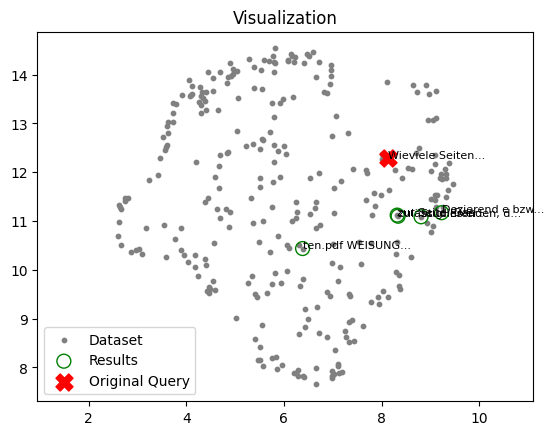

In [94]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

## 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

In [95]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
groq_api_key = os.getenv("GROQ_API_KEY")

# Initialize Groq client
client = Groq(api_key=groq_api_key)

In [96]:
# Load German semantic model
german_model = SentenceTransformer("Sahajtomar/German-semantic")

# Check model dimensions
german_embedding_dim = german_model.get_sentence_embedding_dimension()
print(f"German model embedding dimension: {german_embedding_dim}")
print(f"FAISS index dimension: {index_2.d}")

# Check the token_split_texts_2 length
print(f"Number of texts in token_split_texts_2: {len(token_split_texts_2)}")
print(f"Number of embeddings in FAISS index: {index_2.ntotal}")

German model embedding dimension: 1024
FAISS index dimension: 1024
Number of texts in token_split_texts_2: 297
Number of embeddings in FAISS index: 297


In [97]:
def retrieve_context(query, k=5):
    query_embedding = german_model.encode([query], convert_to_numpy=True)  # <<< FIXED
    
    # Retrieve top-k similar chunks
    distances, indices = index_2.search(query_embedding, k)
    
    # Get the text chunks corresponding to the indices
    retrieved_texts = []
    for i in indices[0]:
        # Make sure the index is valid
        if 0 <= i < len(token_split_texts_2):
            retrieved_texts.append(token_split_texts_2[i])
    
    # If no valid chunks were found, return empty results
    if not retrieved_texts:
        return ["No relevant information found."], np.array([0.0])
    
    return retrieved_texts, distances[0][:len(retrieved_texts)]

In [98]:
def construct_prompt(query, context_chunks):
    """
    Construct a prompt for the LLM using the retrieved context chunks.
    
    Args:
        query (str): The user query
        context_chunks (list): List of retrieved text chunks
        
    Returns:
        str: The constructed prompt
    """
    # Join all context chunks into a single context block
    context = "\n\n".join(context_chunks)
    
    # Build the prompt
    prompt = f"""
You are an AI assistant helping to answer questions based on provided information.

CONTEXT:
{context}

USER QUESTION:
{query}

Please provide a comprehensive answer to the question based only on the information provided in the context. 
If the context doesn't contain enough information to fully answer the question, acknowledge this limitation.
Answer in the same language as the user's question.
"""
    return prompt

In [99]:
def get_llm_answer(prompt):
    """
    Send the prompt to the Groq LLM API and get the response.
    
    Args:
        prompt (str): The constructed prompt
        
    Returns:
        str: The LLM's response
    """
    response = client.chat.completions.create(
        model="llama-3.3-70b-versatile",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1,
        max_tokens=1000,
    )
    
    return response.choices[0].message.content

In [100]:
def answer_question(query, k=5):
    """
    End-to-end function to answer a question using semantic retrieval and LLM.
    
    Args:
        query (str): The user question
        k (int): Number of text chunks to retrieve
        
    Returns:
        dict: Dictionary containing the query, context, and answer
    """
    # Retrieve relevant context chunks
    context_chunks, distances = retrieve_context(query, k)
    
    # Format distances for display
    formatted_distances = [f"{d:.4f}" for d in distances]
    
    # Construct the prompt using the retrieved context
    prompt = construct_prompt(query, context_chunks)
    
    # Get the answer from the LLM
    answer = get_llm_answer(prompt)
    
    # Return all information
    return {
        "query": query,
        "context": context_chunks,
        "distances": formatted_distances,
        "answer": answer
    }

In [101]:
# Example query about using AI in bachelor thesis
example_query = "What is the most important factor in diagnosing asthma?"

# Get answer
result = answer_question(example_query)
# Print the result
print("\n" + "="*80)
print(f"QUERY: {result['query']}")
print("="*80 + "\n")

print("TOP RETRIEVED CHUNKS (with similarity scores):")
for i, (chunk, distance) in enumerate(zip(result['context'], result['distances'])):
    print(f"\n--- Chunk {i+1} (Distance: {distance}) ---")
    print(chunk[:150] + "..." if len(chunk) > 150 else chunk)

print("\n" + "="*80)
print("ANSWER:")
print("="*80)
print(result['answer'])
print("="*80)


QUERY: What is the most important factor in diagnosing asthma?

TOP RETRIEVED CHUNKS (with similarity scores):

--- Chunk 1 (Distance: 553.5703) ---
ch/de/mmr/reference/stabrep_2018/source/stabrep_2018.de Sommaruga, S. (2021, 1. Mai). Wir brauchen weiterhin #Solidarität in unserem Land. [Tweet]. ht...

--- Chunk 2 (Distance: 603.4750) ---
Grenzen und möglichen Ver- zerrungen in den erzeugten Inhalten erkennen, z.B. bei dem Aspekt [...]. Dies förderte ein tieferes Verständnis für die Anw...

--- Chunk 3 (Distance: 604.3669) ---
7. GESETZESTEXTE Institution (Jahr). Titel des Gesetzes. Institution/Verlag. Eidgenössisches Finanzdepartement [EFD] (2011). Verordnung über die Eigen...

--- Chunk 4 (Distance: 613.1789) ---
denken: Thinking (across) Boundaries (S. 1077-1088). Österreichische Gesellschaft für Philosophie. Zitierleitfaden | 12 4. WORKING PAPERS Name, Vornam...

--- Chunk 5 (Distance: 620.1129) ---
Bremen. http://www.timkommission.de/fachtagungen/2004/unterlagen/08_BurrMusil.pdf 

In [102]:
# Try another question about length requirements
second_query = "Wieviele Seiten, wieviel Umfang oder Länge muss meine Bachelorarbeit / Einzelarbeit haben?"
second_result = answer_question(second_query)

# Print the result
print("\n" + "="*80)
print(f"QUERY: {second_result['query']}")
print("="*80 + "\n")

# Manuell suchen:
for i, chunk in enumerate(token_split_texts_2):
    if "40 und maximal 80 Seiten" in chunk:
        print(f"Found in chunk {i}:\n", chunk)


print("TOP RETRIEVED CHUNKS (with similarity scores):")
for i, (chunk, distance) in enumerate(zip(result['context'], result['distances'])):
    print(f"\n--- Chunk {i+1} (Distance: {distance}) ---")
    print(chunk[:150] + "..." if len(chunk) > 150 else chunk)

print("\n" + "="*80)
print("ANSWER:")
print("="*80)
print(second_result['answer'])
print("="*80)


QUERY: Wieviele Seiten, wieviel Umfang oder Länge muss meine Bachelorarbeit / Einzelarbeit haben?

Found in chunk 57:
 klärung zu. 3 Bezug über Intranet W-MB-Merkblatt Bachelorarbeit BSc Version: 3.1.1 gültig ab: 01.08.202 4 Seite 8 von 11 School of Management and Law 11.4 Formale Richtlinien und Umfang Eine Einzelarbeit soll mindestens 40 und maximal 80 Seiten Textteil umfassen (Format A4,
Found in chunk 58:
 School of Management and Law 11.4 Formale Richtlinien und Umfang Eine Einzelarbeit soll mindestens 40 und maximal 80 Seiten Textteil umfassen (Format A4, Zeilenabstand 1.5; Schriftgrösse: Times New Roman 12 Punkt, Seitenrand rechts/links 3 cm). Titelblatt, Verzeichnisse und Anhang werden dabei nicht mitgezählt. Tabellen und andere Darstellungen, die ein abweichendes Format aufweisen, sind gesondert beizulegen. Ausnahmen können durch die Studiengangleitung bewilligt werden. Auf dem Titelblatt müssen zwingend folgende Angaben vorhanden sein: Bachelorarbeit
TOP RETRIEVED CHUNKS (wi

In [103]:
# Visualize the results with the query and retrieved context
def visualize_query_results(query, retrieved_embeddings, k=3):
    """
    Visualize the query and its retrieved results in 2D space using UMAP.
    
    Args:
        query (str): The user query
        retrieved_embeddings (list): Embeddings of retrieved documents
        k (int): Number of results to visualize
    """
    # Encode the query using the same model as the index
    query_embedding = model.encode([query], convert_to_numpy=True)
    
    # Get embeddings for visualization (top k retrieved ones)
    if len(retrieved_embeddings) > k:
        retrieved_embeddings = retrieved_embeddings[:k]
    
    # Project the embeddings
    projected_result_embeddings = project_embeddings(retrieved_embeddings, umap_transform)
    projected_query = project_embeddings(query_embedding, umap_transform)
    
    # Plot
    plt.figure(figsize=(10, 8))
    
    # Scatter plots
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
                s=10, color='gray', alpha=0.3, label='Dataset')
    plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
                s=100, facecolors='none', edgecolors='g', label='Retrieved Results')
    plt.scatter(projected_query[:, 0], projected_query[:, 1],
                s=150, marker='X', color='r', label='Query')
    
    # Annotate query point
    plt.annotate(shorten_text(query),
                 (projected_query[0, 0], projected_query[0, 1]),
                 fontsize=10, fontweight='bold')
    
    # Annotate results
    for i in range(len(projected_result_embeddings)):
        plt.annotate(f"Result {i+1}",
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)
    
    plt.title(f'Query and Retrieved Results Visualization: "{shorten_text(query, 30)}"')
    plt.legend()
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/Users/fp/development/ZHAW/ai_applications/nlp_block/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_fin

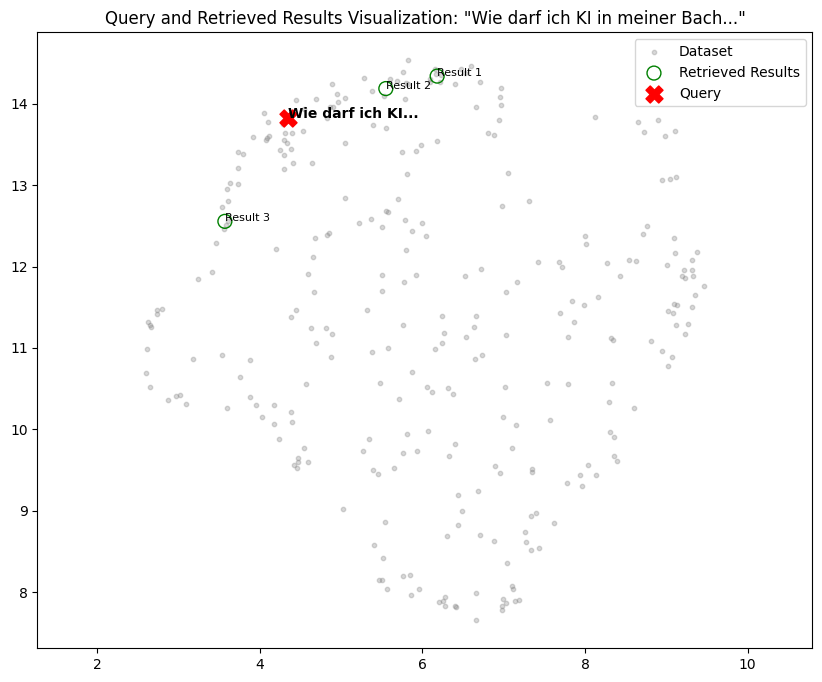

In [104]:
# Get embeddings for visualization
query = "Wie darf ich KI in meiner Bachelorarbeit verwenden?"
retrieved_texts, distances = retrieve_context(query, k=3)
retrieved_embeddings = np.array([model.encode(text, convert_to_numpy=True) for text in retrieved_texts])

# Visualize
visualize_query_results(query, retrieved_embeddings)